In [1]:
import datetime

import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [2]:
df = pd.read_csv("m5-forecasting-accuracy/sales_train_validation.csv")
df["id"] = df["item_id"] + "_" + df["store_id"]
df = df[["id", ] + [cn for cn in df.columns if cn.startswith("d_")]]

df = df.melt(id_vars="id", var_name="timestamp", value_name="value")
df["timestamp"] = pd.to_datetime(df["timestamp"].apply(
    lambda x: datetime.datetime(2011, 1, 28) + datetime.timedelta(days=int(str(x).replace("d_", "")))))

train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="id",
    timestamp_column="timestamp"
)
train_data.head()

,,value
item_id,timestamp,
HOBBIES_1_001_CA_1,2011-01-29,0
HOBBIES_1_002_CA_1,2011-01-29,0
HOBBIES_1_003_CA_1,2011-01-29,0
HOBBIES_1_004_CA_1,2011-01-29,0
HOBBIES_1_005_CA_1,2011-01-29,0


In [3]:
predictor = TimeSeriesPredictor(
    prediction_length=28,
    path="autogluon-m5-daily",
    target="value",
    eval_metric="MASE",
)

predictor.fit(
    train_data,
    presets="best_quality",
    time_limit=12000,
);

Beginning AutoGluon training... Time limit = 12000s
AutoGluon will save models to '/notebooks/autogluon-m5-daily'
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.12.3
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #46~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Jun 7 15:06:04 UTC 20
CPU Count:          8
Pytorch Version:    2.9.1+cu130
CUDA Version:       13.0
GPU Memory:         GPU 0: 15.72/15.72 GB
Total GPU Memory:   Free: 15.72 GB, Allocated: 0.00 GB, Total: 15.72 GB
GPU Count:          1
Memory Avail:       38.05 GB / 44.08 GB (86.3%)
Disk Space Avail:   189627.73 GB / 438278.40 GB (43.3%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 'auto',
 'prediction_length': 28,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_

In [4]:
predictor.leaderboard()

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-1.381688,358.026092,204.707486,10
1,Chronos2,-1.385810,192.236011,205.353043,4
2,Chronos2SmallFineTuned,-1.394204,39.223105,253.883637,5
3,TemporalFusionTransformer,-1.394392,22.107094,329.846206,8
4,ChronosWithRegressor[bolt_small],-1.405312,37.709805,82.720322,7
5,DeepAR,-1.430435,66.240728,272.404027,9
6,AutoETS,-1.672171,656.402950,681.459280,6
7,DirectTabular,-1.719939,40.001103,145.152922,3
8,SeasonalNaive,-1.870854,19.782137,50.692468,1
9,RecursiveTabular,-1.936677,33.397192,179.265783,2


In [8]:
predictions = predictor.predict(train_data)
my_predictions = predictions.reset_index().rename(columns={"item_id": "id", "mean": "predictions"})
my_predictions

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


,id,timestamp,predictions,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,HOBBIES_1_001_CA_1,2016-04-25,0.358965,-0.023403,0.004316,0.057915,0.145288,0.358965,0.811604,1.219004,1.671278,2.322538
1,HOBBIES_1_001_CA_1,2016-04-26,0.357101,-0.024783,-0.003203,0.040713,0.124479,0.357101,0.831037,1.226045,1.683941,2.324326
2,HOBBIES_1_001_CA_1,2016-04-27,0.354656,-0.023521,-0.000197,0.036036,0.121665,0.354656,0.826978,1.223251,1.682871,2.315449
3,HOBBIES_1_001_CA_1,2016-04-28,0.359767,-0.029269,0.007106,0.035407,0.135729,0.359767,0.814015,1.216091,1.680948,2.334356
4,HOBBIES_1_001_CA_1,2016-04-29,0.441259,-0.042202,0.007685,0.076671,0.211837,0.441259,0.884676,1.321934,1.780697,2.458913
...,...,...,...,...,...,...,...,...,...,...,...,...
853715,FOODS_3_827_WI_3,2016-05-18,0.050994,-0.033582,-0.032187,0.006103,0.014586,0.050994,0.213147,0.550497,1.114211,2.811539
853716,FOODS_3_827_WI_3,2016-05-19,0.052119,-0.028184,-0.023734,0.009281,0.017205,0.052119,0.214197,0.548346,1.109243,2.811457
853717,FOODS_3_827_WI_3,2016-05-20,0.068133,-0.022297,-0.015527,0.020303,0.024343,0.068133,0.241513,0.601752,1.208931,2.927061
853718,FOODS_3_827_WI_3,2016-05-21,0.069097,-0.021048,-0.016792,0.022097,0.017638,0.069097,0.261375,0.637713,1.284429,3.056707


In [6]:
test_df = pd.read_csv("m5-forecasting-accuracy/sales_train_evaluation.csv")
test_df["id"] = test_df["item_id"] + "_" + test_df["store_id"]
test_df = test_df[test_df["id"].isin(df["id"].unique())]
test_df = test_df[["id", ] + [cn for cn in test_df.columns if cn.startswith("d_")]]
test_df = test_df.melt(id_vars="id", var_name="timestamp", value_name="value")

test_df["timestamp"] = pd.to_datetime(test_df["timestamp"].apply(
    lambda x: datetime.datetime(2011, 1, 28) + datetime.timedelta(days=int(str(x).replace("d_", "")))))

test_data = TimeSeriesDataFrame.from_data_frame(
    test_df,
    id_column="id",
    timestamp_column="timestamp"
)
test_data

,,value
item_id,timestamp,
HOBBIES_1_001_CA_1,2011-01-29,0
HOBBIES_1_002_CA_1,2011-01-29,0
HOBBIES_1_003_CA_1,2011-01-29,0
HOBBIES_1_004_CA_1,2011-01-29,0
HOBBIES_1_005_CA_1,2011-01-29,0
...,...,...
FOODS_3_823_WI_3,2016-05-22,1
FOODS_3_824_WI_3,2016-05-22,0
FOODS_3_825_WI_3,2016-05-22,2


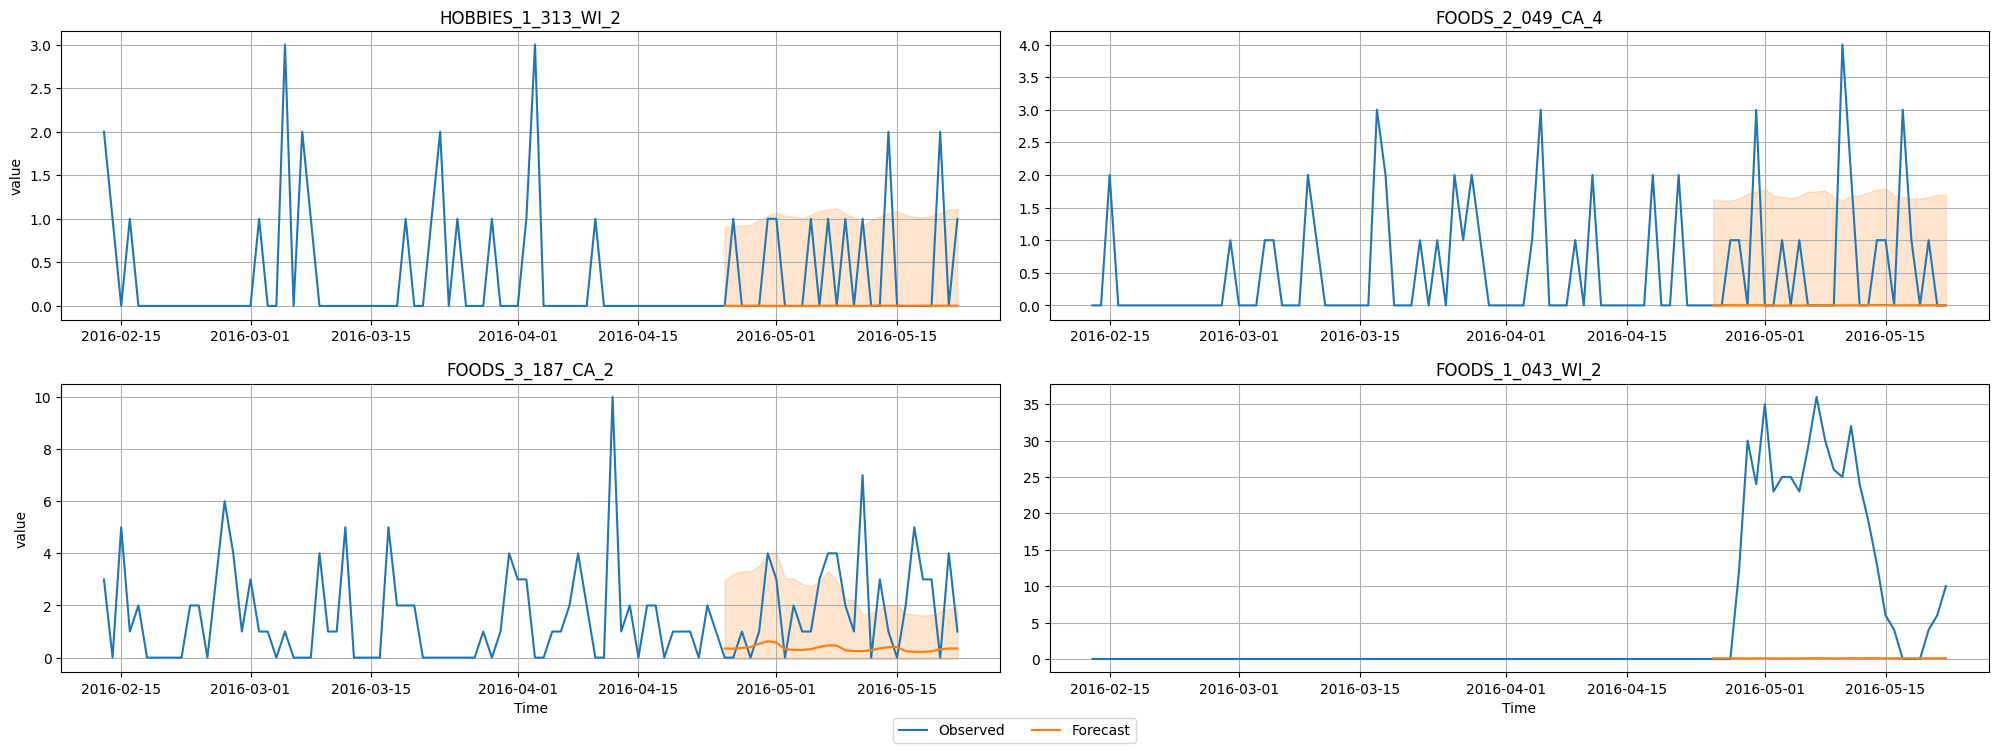

In [9]:
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=100, max_num_item_ids=4);

In [10]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-1.340959,-1.381688,399.791588,358.026092,204.707486,10
1,Chronos2,-1.344719,-1.385810,188.418341,192.236011,205.353043,4
2,TemporalFusionTransformer,-1.352492,-1.394392,24.888759,22.107094,329.846206,8
3,Chronos2SmallFineTuned,-1.353523,-1.394204,56.489932,39.223105,253.883637,5
4,ChronosWithRegressor[bolt_small],-1.363892,-1.405312,40.259518,37.709805,82.720322,7
5,DeepAR,-1.389991,-1.430435,89.167676,66.240728,272.404027,9
6,AutoETS,-1.593468,-1.672171,665.817624,656.402950,681.459280,6
7,DirectTabular,-1.639029,-1.719939,39.007400,40.001103,145.152922,3
8,SeasonalNaive,-1.810144,-1.870854,18.216237,19.782137,50.692468,1
9,RecursiveTabular,-1.820446,-1.936677,33.507303,33.397192,179.265783,2


In [11]:
import matplotlib.pyplot as plt

# Visualization helper function
def plot_forecast(
        context_df: pd.DataFrame,
        pred_df: pd.DataFrame,
        test_df: pd.DataFrame,
        target_column: str,
        timeseries_id: str,
        id_column: str = "id",
        timestamp_column: str = "timestamp",
        history_length: int = 256,
        title_suffix: str = "",
):
    ts_context = context_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]
    ts_pred = pred_df.query(f"{id_column} == @timeseries_id").set_index(
        timestamp_column
    )[["0.1", "predictions", "0.9"]]
    ts_ground_truth = test_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]
    
    last_date = ts_context.index.max()
    start_idx = max(0, len(ts_context) - history_length)
    plot_cutoff = ts_context.index[start_idx]
    ts_context = ts_context[ts_context.index >= plot_cutoff]
    ts_pred = ts_pred[ts_pred.index >= plot_cutoff]
    ts_ground_truth = ts_ground_truth[ts_ground_truth.index >= plot_cutoff]

    fig = plt.figure(figsize=(12, 3))
    ax = fig.gca()
    ts_context.plot(ax=ax, label=f"historical {target_column}", color="xkcd:azure")
    ts_ground_truth.plot(ax=ax, label=f"future {target_column} (ground truth)", color="xkcd:grass green")
    ts_pred["predictions"].plot(ax=ax, label="forecast", color="xkcd:violet")
    ax.fill_between(
        ts_pred.index,
        ts_pred["0.1"],
        ts_pred["0.9"],
        alpha=0.7,
        label="prediction interval",
        color="xkcd:light lavender",
    )
    ax.axvline(x=last_date, color="black", linestyle="--", alpha=0.5)
    ax.legend(loc="upper left")
    ax.set_title(f"{target_column} forecast for {timeseries_id} {title_suffix}")
    fig.show()

In [12]:
id = df.groupby("id")["value"].mean().idxmax()
id

'FOODS_3_090_CA_3'

In [15]:
plot_forecast(
    df,
    my_predictions,
    test_df,
    target_column="value",
    timeseries_id=id,
    title_suffix="(autogluon)",
)

In [16]:
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

merged_df = my_predictions.merge(test_df, on=["id", "timestamp"], how="inner")

print(mean_absolute_scaled_error(merged_df["value"], merged_df["predictions"], y_train=df["value"]))

0.5303297363021601
